# Is it OK to long term hold leveraged ETF's?
Theres an idea that you should not hold onto leveraged ETF's for the long term. Here I will show through a monte carlo simulation of the Nasdaq 100, that long term holding leveraged ETF's are completely fine if the person holding has the nessecary risk tolerance.

First, what are leveraged ETF's?
A leveraged ETF is a security that tracks a given index with a certain leverage. Through the use of derivatives the managers of a leveraged ETF are able to magnify the daily movements of an index by a certain multiplier. Common leverage magnitudes include 3, 2, -1, and 3. Note that what is magnified is daily movements, therefore, it is possible that the annual return on an index is not equivalent to annual return on the leveraged ETF divided by leverage.

In my belief, leveraged ETF's are an excellent way for risk tolerant investors with long time horizons to increase their gains with relatively low fees and the tax benefits of ETF's.

The main purpose of this notebook is actually to demonstrate how to create market simulations with some given assumptions and observations about the nature of security returns then test out ideas without having to understand complex theories.

In [23]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as smt
from statsmodels import graphics
from scipy import stats
from datetime import datetime

195.63308658055814


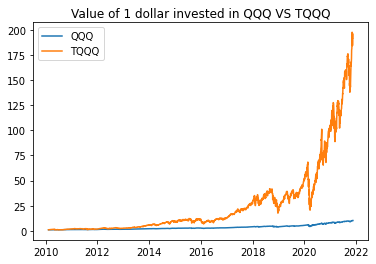

In [2]:
#read csv files for our data
QQQ = pd.read_csv('QQQ.csv')
TQQQ = pd.read_csv('TQQQ.csv')

def date_array(series):
    '''
    Turns the string form of a yahoo finance dataframe into its datetime form
    '''
    series_copy = series.copy()
    for i in range(len(series)):
        series_copy[i] = datetime.strptime(series_copy[i], '%Y-%m-%d')
    return series_copy

#make it so they start on the same day
start_date = TQQQ['Date'][0]
start_index = pd.Index(QQQ['Date']).get_loc(start_date)

plt.plot(date_array(QQQ['Date'])[start_index:], QQQ['Adj Close'][start_index:] / QQQ['Adj Close'][start_index])
plt.plot(date_array(TQQQ['Date']), TQQQ['Adj Close'] / TQQQ['Adj Close'][0])
plt.title('Value of 1 dollar invested in QQQ VS TQQQ')
plt.legend(['QQQ', 'TQQQ'])
print(TQQQ['Adj Close'][len(TQQQ['Adj Close']) - 1] / TQQQ['Adj Close'][0])

QQQ is a traditional ETF tracking the Nasdaq 100, TQQQ is a 3x leveraged ETF tracking the Nasdaq 100. As we can see TQQQ over the last 11 years in terms of price has certainly outperformed QQQ with flying colors, achieving well over 3x QQQ's performance. However, those that argue against the long term holding of leveraged ETF's have a valid argument that the sample shows one of history's greatest bull markets so of course a leveraged ETF would do well. Lets use Nasdaq 100 data to see what would have  happened to TQQQ if it were around when the dot com bubble popped.

0.0006713635395133376


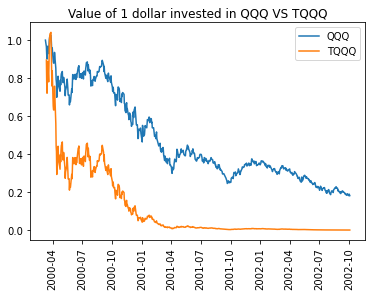

In [3]:
NDX = pd.read_csv('^NDX.csv')
TNDX = []
start_index = pd.Index(NDX['Date']).get_loc('2000-03-10')
end_index = pd.Index(NDX['Date']).get_loc('2002-10-04')
frame = NDX['Adj Close'][start_index : end_index].to_numpy()
for i in range(1, len(frame)):
    TNDX += [((frame[i] / frame[i - 1] - 1) * 3) + 1]
for i in range(1, len(TNDX)):
    TNDX[i] = TNDX[i] * TNDX[i - 1]
plt.plot(date_array(NDX['Date'])[start_index:end_index], NDX['Adj Close'][start_index:end_index] / NDX['Adj Close'][start_index])
plt.plot(date_array(NDX['Date'])[start_index + 1:end_index], TNDX)
plt.xticks(rotation=90)
plt.title('Value of 1 dollar invested in QQQ VS TQQQ')
plt.legend(['QQQ', 'TQQQ'])
print(TNDX[-1])

While QQQ took a big hit losing 80% of its value, it is not an unrecoverable position, the same investment would have returned to its original value by 2017. However, 1 dollar of TQQQ on March 10, 2000 would be worth 0.0006713635395133376 by October 4th, 2002, we'd have to multiply by 1489 times in order to recover. So who is right? Both arguments present curated historical data and are based on one of the many random paths our market could have taken to get to where it is today. So in order to solve the problem, we use Monte Carlo Simulations. We simulate thousands of timelines in which the market could have moved and test the performance of leverage on multiple timelines. But first, let us study the unique statistical properties of QQQ's movements before we rush into creating our model.

DescribeResult(nobs=array(9107, dtype=int64), minmax=(masked_array(data=-0.15077616,
             mask=False,
       fill_value=1e+20), masked_array(data=0.18771308,
             mask=False,
       fill_value=1e+20)), mean=0.000682632817400873, variance=0.00027137256998610457, skewness=masked_array(data=0.07551062,
             mask=False,
       fill_value=1e+20), kurtosis=8.255048040947358)
Jarque_beraResult(statistic=25867.15304489905, pvalue=0.0)


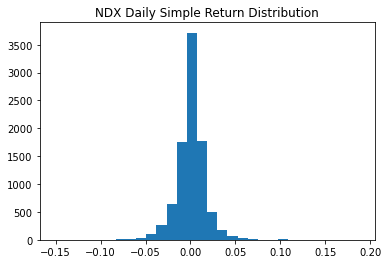

In [31]:
NDX = pd.read_csv('^NDX.csv')
NDX.rename(columns={'Adj Close':'Adj_Close'}, inplace = True)
NDX['Simple_Rtn'] = NDX.Adj_Close.pct_change()
NDX['Log_Rtn'] = np.log(NDX.Adj_Close / NDX.Adj_Close.shift(1))
plt.hist(NDX['Simple_Rtn'], bins = 30)
plt.title('NDX Daily Simple Return Distribution')
print(stats.mstats.describe(NDX['Simple_Rtn'][1:]))
print(stats.jarque_bera(NDX['Simple_Rtn'][1:]))

Here we have the statistical distribution of the daily returns we note the following properties of this distribution.

Moment 1: We have a mean of 0.000682632817400873 as the market generally goes up

Moment 2: We have a variance of 0.07551062

Moment 3: We have a skewness of 0.22972069 which means our tail is on the right side

Moment 4: We have a kurtosis of 8.255048040947358 which means our distribution has much fatter tails than the normal distribution making it achieve extreme positives and negatives more often than they appear in a normal distribution

Through the Jarque-Bera Test we find theres a p-value of 0.0 that a normal distribution would generate a distribution with the skewness and kurtosis we observe.

Text(0.5, 1.0, 'NDX Daily Simple Returns')

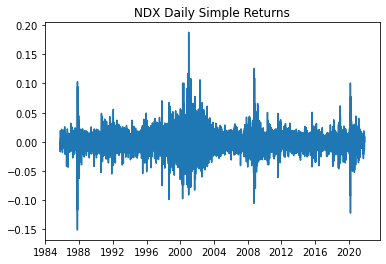

In [32]:
plt.plot(date_array(NDX['Date']), NDX['Simple_Rtn'])
plt.title('NDX Daily Simple Returns')

Text(0.5, 1.0, 'NDX Realized Monthly Volatility')

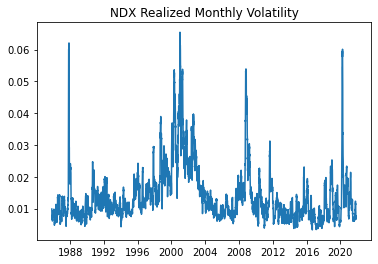

In [34]:
NDX['Monthly_Volatility'] = NDX[['Log_Rtn']].rolling(window=21).std()
plt.plot(date_array(NDX['Date']), NDX['Monthly_Volatility'])
plt.title('NDX Realized Monthly Volatility')

From this plot we can see that obviously, volatility is not constant but instead is clustered. Volatility spikes during financial crises such as 1987, 2001, 2008 and 2020. After spiking, it gradually will return to a base level. In order to create the most representative model possible during our Monte Carlo Simulation we need to incorporate these statistical features into our model.

We start off by using generalized autoregressive conditional heteroskedasticity or GARCH to generate random volatility time series based off of observed parameters.
